In [1]:
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import models
from torchvision.transforms import *
import matplotlib.pyplot as plt
from torch import nn
from torch.optim.lr_scheduler import *
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCH = 4
NUM_CLASSES = 12
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def get_dataloaders():

    def label_onehot(l):
        t = torch.zeros(NUM_CLASSES, dtype=torch.float)
        t[l] = 1
        return t

    trT = Compose([
        Resize((256,256)),
        RandomVerticalFlip(),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    valT = Compose([
        Resize((256,256)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    trSet = ImageFolder("za_torch_splited/train", trT, label_onehot)
    valSet = ImageFolder("za_torch_splited/val", valT, label_onehot)
    teSet = datasets.ImageFolder("za_torch_splited/test", valT, label_onehot)

    trLoader = DataLoader(trSet, BATCH_SIZE, shuffle=True)
    valLoader = DataLoader(valSet, BATCH_SIZE, shuffle=True)
    teLoader = DataLoader(teSet, BATCH_SIZE)

    return trLoader, valLoader, teLoader

In [4]:
class BugNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = models.resnet18(pretrained=True)
        num_fltrs = self.net.fc.in_features
        self.net.fc = nn.Linear(num_fltrs, NUM_CLASSES)

    def forward(self, x):
        predictions = self.net(x)
        return predictions

In [5]:
from torch.utils.tensorboard import SummaryWriter

def train_loop(dataloader: DataLoader, model: BugNet, loss_fn, optimizer: torch.optim.Optimizer):
    train_loss = 0    
    num_batches = len(dataloader)
    train_loss /= num_batches

    correct1 = 0


    model.train()
    size = len(dataloader.dataset)

    counter = 0
    for batchIdx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batchIdx % 10 == 0:
            loss, current = loss.item(), batchIdx * len(X)
                    
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

        eqMask = (pred.argmax(1) == y.argmax(1)).type(torch.float) #dodano
        correct1 += eqMask.sum().item() #dodano
        
        counter += 1
    correct1 /= size
    correct1 *= 100    
    
            
    return train_loss, counter, correct1

In [6]:
def test_loop(dataloader: DataLoader, model: BugNet, loss_fn, prefix="val"):
    model.eval()
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            eqMask = (pred.argmax(1) == y.argmax(1)).type(torch.float)
            correct += eqMask.sum().item()

        test_loss /= num_batches
        correct /= size
        correct *= 100
  
        print(f"{prefix} Error: \n Accuracy: {correct :>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct, test_loss

In [7]:
if __name__ == "__main__":
    writer = SummaryWriter()

    losses_val = []
    losses_train = []
    accuracy_train = []
    accuracy_val = []

    tr_loader, val_loader, te_loader = get_dataloaders()
    model = BugNet().to(device)
    loss_fn = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = ReduceLROnPlateau(optimizer=optimizer, verbose=True, mode="max", patience=10, cooldown=6, min_lr=0.00001) #isprobati sto prije

    accuracy = 0
    for t in range(EPOCH):
        print(f"Epochs {t+1}\n------------------------------")
        loss_train, counter, correct1 = train_loop(tr_loader, model, loss_fn, optimizer)
        correct, loss_test = test_loop(val_loader, model, loss_fn, "validation")
        scheduler.step(loss_test)

        writer.add_scalar("Loss", loss_train, t)

        if correct > accuracy:
            torch.save(model, 'best-model.pt')
            print("new best model saved!")
            accuracy = correct

        losses_val.append(loss_test)
        losses_train.append(loss_train.item()/counter)
        accuracy_val.append(correct)
        accuracy_train.append(correct1)
    
        # print("counter: ", counter)
        # print("loss_val: ", loss_test)
        # print("loss_train: ", loss_train)
        # print("correct_val: ", correct)
        # print("correct_train: ", correct1)
        
    test_loop(te_loader, model, loss_fn, "test")


print("Done!")

Epochs 1
------------------------------
loss: 2.783870 [    0/ 3862]
loss: 0.615637 [  320/ 3862]
loss: 0.494963 [  640/ 3862]
loss: 0.484474 [  960/ 3862]
loss: 0.374064 [ 1280/ 3862]
loss: 0.132589 [ 1600/ 3862]
loss: 0.163881 [ 1920/ 3862]
loss: 0.491142 [ 2240/ 3862]
loss: 0.574878 [ 2560/ 3862]
loss: 0.181111 [ 2880/ 3862]
loss: 0.362918 [ 3200/ 3862]
loss: 0.358448 [ 3520/ 3862]
loss: 0.325596 [ 2640/ 3862]
validation Error: 
 Accuracy: 78.3%, Avg loss: 0.868448 

new best model saved!
Epochs 2
------------------------------
loss: 0.138782 [    0/ 3862]
loss: 0.151051 [  320/ 3862]
loss: 0.230731 [  640/ 3862]
loss: 0.179524 [  960/ 3862]
loss: 0.111154 [ 1280/ 3862]
loss: 0.165895 [ 1600/ 3862]
loss: 0.189029 [ 1920/ 3862]
loss: 0.285467 [ 2240/ 3862]
loss: 0.101413 [ 2560/ 3862]
loss: 0.070991 [ 2880/ 3862]
loss: 0.043515 [ 3200/ 3862]
loss: 0.231652 [ 3520/ 3862]
loss: 0.036463 [ 2640/ 3862]
validation Error: 
 Accuracy: 92.0%, Avg loss: 0.263458 

new best model saved!
Epochs

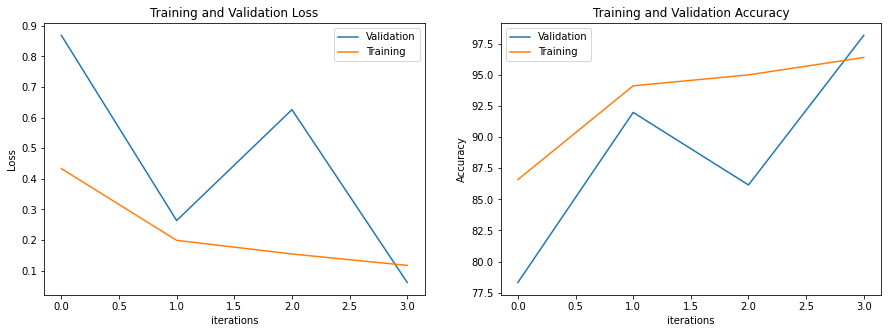

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Training and Validation Loss")
plt.plot(losses_val, label="Validation")
plt.plot(losses_train, label="Training")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Training and Validation Accuracy")
plt.plot(accuracy_val, label="Validation")
plt.plot(accuracy_train, label="Training")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
# #convert to numpy to show image
# def imshow(img):
#   img = img / 2 + 0.5 # unnormalize
#   npimg = img.numpy() # convert to numpy objects
#   plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='nearest')
#   plt.show()

In [10]:
model = BugNet()
model = torch.load('torch_model/best-model.pt')
model.eval()

BugNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [11]:
_, _, teLoader = get_dataloaders()

dataset = datasets.ImageFolder("za_torch_splited/test", transform=teLoader)
target_labels = dataset.classes
print(target_labels)

['adalia bipunctata', 'calliteara pudibunda', 'cerambyx cerdo', 'gryllotalpa gryllotalpa', 'lucanus cervus', 'mantis religiosa', 'melolontha melolontha', 'phyrrochorus apterus', 'rhaphigaster nebulosa', 'sesia apiformis', 'tettigonia viridissima', 'xylocopa violacea']


In [12]:
image_transforms = Compose([
    Resize((256,256)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
### Predict a single image ###

# def classify(model, image_transform, image_path, classes):
#     model = model.eval()
#     image = Image.open(image_path)
#     image = image_transform(image).float()
#     image = image.unsqueeze(0)
#
#     output = model(image)
#     _, predicted = torch.max(output.data, 1)
#     print(classes[predicted.item()])
#
#
# classify(model, image_transforms, "frame3765.jpg", classes)

In [14]:
### Accuracy of the network on the test images ###

# teSet = datasets.ImageFolder("pyth_insect_splited/test", image_transforms)
# teLoader = DataLoader(teSet, BATCH_SIZE)
# dataiter = iter(teLoader)
#
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in dataiter:
#         images, labels = data
#
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#
# print('Accuracy of the network on the test images: %d %%' % (
#     100 * correct / total))

In [15]:
### Plot images with their respective accuracies, version 1.0 ###

# teSet = datasets.ImageFolder("pyth_insect_splited/test", image_transforms)
# teLoader = DataLoader(teSet, BATCH_SIZE)
# dataiter = iter(teLoader)
# images, labels = dataiter.next()
# print(images.shape, labels.shape)

# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(20)))
#
# outputs = model(images)
# _, predicted = torch.max(outputs, 1)
# print('Predicted:   ', ' '.join('%s' % classes[predicted[j]] for j in range(20)))

torch.Size([32, 3, 256, 256]) torch.Size([32, 12])
images torch.Size([32, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


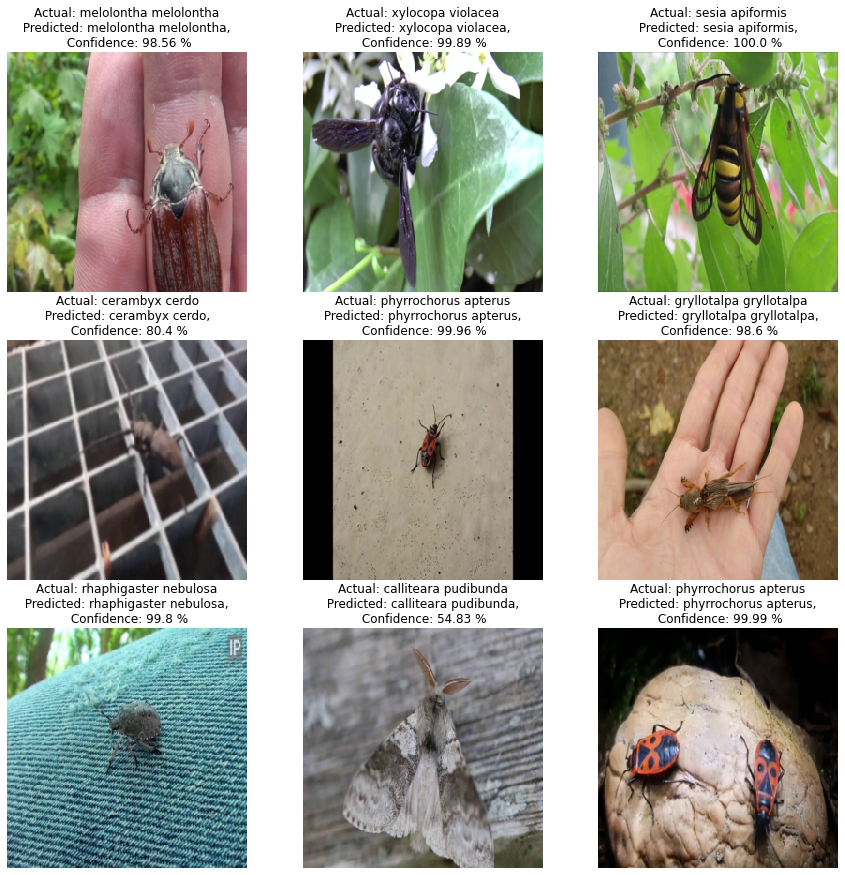

In [16]:
### Plot images with their respective accuracies, version 2.0 ###

def label_onehot(l):
    t = torch.zeros(NUM_CLASSES, dtype=torch.float)
    t[l] = 1
    return t

teSet = datasets.ImageFolder("za_torch_splited/test", image_transforms, label_onehot)
teLoader = DataLoader(teSet, BATCH_SIZE, shuffle=True)
dataiter = iter(teLoader)
images, labels = next(dataiter)
print(images.shape, labels.shape)
images = images.to(device)
labels = labels.to(device)

print("images", images.shape)

outputs = model(images)

outputs = nn.Softmax(dim=1)(outputs).cpu().detach().numpy()

def imshow(image):
    npimg = image.cpu().numpy()
    npimg = np.transpose(npimg, (1,2,0))
    npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
    plt.imshow(npimg, interpolation='nearest')


plt.figure(figsize=(15,15))
for i in range(9): 
    actual = target_labels[np.argmax(labels[i].cpu().numpy())]
    predct = target_labels[np.argmax(outputs[i])]
    confidence = round(100*(np.max(outputs[i])), 2)

    ax = plt.subplot(3,3, i+1)
    imshow(images[i])
    plt.title(f"Actual: {actual}\n Predicted: {predct}, \n Confidence: {confidence} %")
    plt.axis('off')

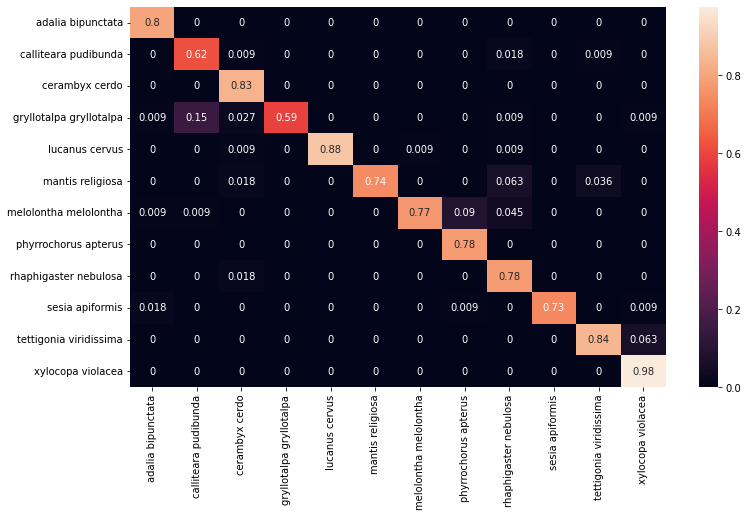

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for images, labels in teLoader:
    outputs = model(images.to(device))
    outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    y_pred.extend(outputs)
    #print("y_pred: ", len(y_pred))


    labels = labels.data.cpu().numpy()
    labels = np.argmax(labels, axis=1)
    y_true.extend(labels)
    #print("labels: ", len(y_true))

    #print("y_true: ", y_true)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in target_labels],
                     columns = [i for i in target_labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')